In [1]:
from qaoa import QAOA, problems, mixers, initialstates

import matplotlib.pyplot as plt
import datetime

from qiskit_finance.data_providers import RandomDataProvider

import os
import sys

sys.path.append("../")
from plotroutines import *

import itertools

In finance, portfolio optimization aims at finding optimal investments maximizing a trade-off between return and risks, given
some constraints. Classical formulations of this quadratic optimization problem have exact or heuristic solutions, but the
complexity scales up as the market dimension increases. The optimization problem aims at finding optimal values of investments, which
may be expressed as continuous variables (in terms of the fraction of budget to invest), but due to their discrete nature, are
better represented as integers (in terms of the number of assets units to buy or sell) or binary variables (obtained by the binary
encoding of integers).

For each asset i, with $1\leq i \leq N$, the temporal range between $t_{1}$ and $t_{2}$ is
considered. For each day t in this range ($0\leq t \leq T$), the performance of an asset is well represented by its closing price $p^{t}_{i}$. 

The first information extracted from this data set consists in the list P of current prices $p_{i}$ of the considered assets.

The return $r_{i}^{t}$ between two days $t-1$ and $t$ can be calculated as: 

$r_{i}^{t}=\frac{p_{i}^{t}-p_{i}^{t-1}}{p_{i}^{t-1}}$


Given the entire historical data set, the expected return of each asset $\mu_{i}$ is calculate as the mean of their values at each time t:

 $\mu_{i}=E[r_{i}]=\frac{1}{T}\sum_{t=1}^{T}r_{i}^{t}$. 

Similarly we can estimate the variance and the covariance between the returns of the different assets over the historical series as:

$\sigma_{i}^{2}=E[(r_{i}-\mu_{i})^{2}]=\frac{1}{T-1}\sum_{t=1}^{T}(r_{i}^{t}-\mu_{i})^{2}$

$\sigma_{ij}=E[(r_{i}-\mu_{i})(r_{j}-\mu_{j})]=\frac{1}{T-1}\sum_{t=1}^{T}(r_{i}^{t}-\mu_{i})(r_{j}^{t}-\mu_{j})$

# Step 1: Generate Time Series Data 

In [2]:
class AssetData:
    def __init__(
        self, N_assets, num_days=101, seed=0, start_time=datetime.datetime(2020, 1, 1)
    ):
        """
        init function that initializes member variables

        :param params: additional parameters
        """
        self.N = N_assets
        self.num_days = num_days
        self.start_time = start_time
        self.end_time = start_time + datetime.timedelta(self.num_days)

        self.tickers = [("ASSET%s" % i) for i in range(self.N)]
        self.fin_data = RandomDataProvider(
            tickers=self.tickers, start=self.start_time, end=self.end_time, seed=seed
        )
        self.fin_data.run()

        self.cov_matrix = self.fin_data.get_period_return_covariance_matrix()
        self.exp_return = self.fin_data.get_period_return_mean_vector()

    def plotAssets(self, figsize=(12, 4)):
        fig = plt.figure(figsize=figsize)
        gs = fig.add_gridspec(1, 3)
        axs = [None] * 2
        axs[0] = fig.add_subplot(gs[0, 0:2])
        t = [self.start_time + datetime.timedelta(dt) for dt in range(self.num_days)]
        for i, ticker in enumerate(self.tickers):
            axs[0].plot(t, self.fin_data._data[i], label=ticker)
        axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=-30)
        axs[0].legend()
        axs[0].set_title("time development")

        axs[1] = fig.add_subplot(gs[0, 2])
        im = axs[1].imshow(self.cov_matrix)
        fig.colorbar(im, ax=axs[1], shrink=0.8)


# Step 2: Formulate the Problem 

The aim is to achive the best portfolio return $\mu^{T}x$ while mimimizing the risk defined as the portfolio variance $x^{T}\Sigma x$ where $\mu$ is the vector of the mean asets return and $\Sigma $ is the coviariance matrix

Hence trhe task of finding the optimal portfolio aims at finding the x vector that maximizes the cost function defined as:

$C(x)=\mu^{T}x-q x^{T}\Sigma x$

where the risk aversion parameter q express the propensity to risk of the investor. But in realistic scenarios the available budget B is fixed so we need to put a constrain on the set of investments $x_{i}$.

The problem, in general, can be expressed as follows:

$max_{x} C(x) : max_{x}(\mu^{T}x-q x^{T}\Sigma x)$

s.t $\sum_{i=1}^{N}x_{i}=B$


C:\Users\rubenb\AppData\Local\Temp\ipykernel_15644\3827616524.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=-30)


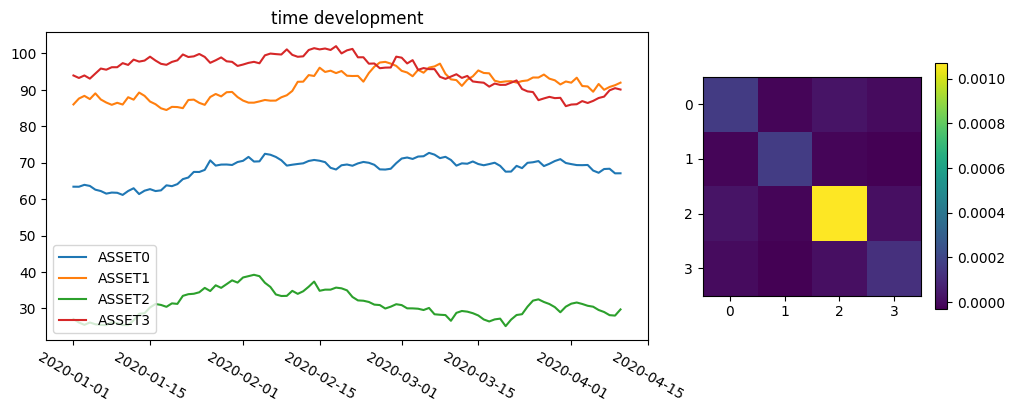

In [3]:
number_of_assets = 4
budget = 2
risk=0.5


filename = os.path.join(
    "data", "qiskit_finance_seeds.npz"
)  # filename of file containing time series of
# non-crashing stocks.
seeds = np.load(filename)
assets = AssetData(number_of_assets, seed=seeds[str(number_of_assets)][132])

assets.plotAssets()

# Step 3: Ising formulation of the Cost Function 

To be quantum-native, it has to be converted into a Quadratic Unbounded Binary Optimization (QUBO) problem that can be mapped into a Spin Hamiltonian. To do so the target vector to be found should be expressed as a vector of zeros and ones and we need to find a way to take in consideration the constraints.




HOW TO TRANSOFRM TH EPROBLEMN TO BINARY 

To convert the new cost function into an Quadratic Ising Hamiltonian we just need to map the bits into spin variables using the transformation:

$b_{i}\rightarrow\frac{1+s_{i}}{2}$

and re-arranging the coefficients we can obtain the Ising objective function to be minimized defined as:

$min_{s}C(s): min_{s} (\sum_{i}h_{i}s_{i}+\sum_{i,j}J_{ij}s_{i}s_{j})$

The Quantum version of this objective function can be obtained substituting the $s_{i}$ spin variables with the $\sigma^{z}=\bigl(\begin{smallmatrix}
1 & 0\\ 
0 & -1
\end{smallmatrix}\bigr)$ pauli operator 

$H_{P}=(\sum_{i}h_{i}\sigma^{z}_{i}+\sum_{i,j}J_{ij}\sigma^{z}_{i}\sigma^{z}_{j})$ with $E_{GS}=min_{s}C(s)$

# Quantum Alterning Operator Ansatz

The Quantum Ising Hamiltonian $H_{P}$, usually called in the QAOA formalism Phase or Problem Hamiltonian, is a diagnal operator that acts on the computational basis as:

$H_{P}\ket{x}=c(x)\ket{x}$

which means that the ground state is a computational basis state.

The QAOA ansatz consist of p layers of alternating two operators called respectively Mixer and Problem Operators. The ansatz wavefunction has the following form:

$\ket{\gamma,\beta}= \prod_{l=1}^{p}(U_{M}(\beta_{l})U_{P}(\gamma_{l}))\ket{\psi_{0}}$

where

$U_{M}$ is the Mixing operator that ensure transitions between all the possible feasible states


$U_{P}$ is the Phase Operator that has the form $U_{P}=e^{-i\gamma H_{P}}$

$\ket{\psi_{0}}$ is the initial state 




## The Penalty Method 

In the standard QAOA the minimization is performed with respect to all states, so in particular in the whole n qubits Hilbert Space. For the standard QAOA the the mixing operator can be expressed as $U_{M}=e^{-i\beta{H_{M}}}, H_{M}=\sum_{i=1}^{N}\sigma^{x}_{i}$ and the initial state is the equal superposition of all the possible solutions $\ket{\psi_{0}}=\frac{1}{2^{N}}\sum_{i}\ket{i}=\ket{+}^{\otimes N}$ 

In the Portofolio Optimization case we have to deal with the budget constraint $\sum_{i}x_{i}=B$. In order to deal with the constrain we can modify the cost function including a penalty term that penalizes enough the unfeasible states

$H_{pen}=H_{p}+p(\sum_{i}\frac{1+\sigma^{z}_{i}}{2}-B)^{2} $

The penalty factor should be chosen enough large such that all unfeasible states have a cost function greater than the feasible ones. On the other hand we have to be careful because if the penalty factor p is too large the QAOA are expected to deteriorate  

In [4]:
def get_problem(penalty=None,rescaling=1):
    if not penalty:
        return problems.PortfolioOptimization(
            risk=risk,
            budget=budget,
            cov_matrix=assets.cov_matrix*rescaling,
            exp_return=assets.exp_return*rescaling,
        )
    else:
        return problems.PortfolioOptimization(
            risk=risk,
            budget=budget,
            cov_matrix=assets.cov_matrix*rescaling,
            exp_return=assets.exp_return*rescaling,
            penalty=penalty,
        )

In [5]:
penalty=100

Q = risk * np.tril(
    assets.cov_matrix + np.tril(assets.cov_matrix, k=-1)
) + penalty * (
    np.eye(number_of_assets)
    + 2 * np.tril(np.ones((number_of_assets,number_of_assets)), k=-1)
)
c = -assets.exp_return - (
    2 * penalty * budget * np.ones_like(assets.exp_return)
)
b = penalty * budget * budget

print(Q)
print(c)
print(b)


[[100.00007883   0.           0.           0.        ]
 [199.99998202 100.00008049   0.           0.        ]
 [200.00002588 199.99998074 100.00053528   0.        ]
 [200.00000014 199.99996647 200.00001313 100.0000597 ]]
[-400.00064213 -400.00075183 -400.00146528 -399.99963985]
400


In [6]:
qaoa_penalty = QAOA(
    initialstate=initialstates.Plus(),
    problem=get_problem(0,1),
    mixer=mixers.X()
)

2023-10-12 16:58:42 [info     ] Calculating energy landscape for depth p=1... file=qaoa.qaoa func=sample_cost_landscape
1 0
2023-10-12 16:58:42 [info     ] Executing sample_cost_landscape file=qaoa.qaoa func=sample_cost_landscape
2023-10-12 16:58:42 [info     ] parameters: 2                  file=qaoa.qaoa func=sample_cost_landscape
2023-10-12 16:58:43 [info     ] Done execute                   file=qaoa.qaoa func=sample_cost_landscape
2023-10-12 16:58:44 [info     ] Done measurement               file=qaoa.qaoa func=sample_cost_landscape
2023-10-12 16:58:44 [info     ] Calculating Energy landscape done file=qaoa.qaoa func=sample_cost_landscape


Text(0.5, 1.0, 'penalty method')

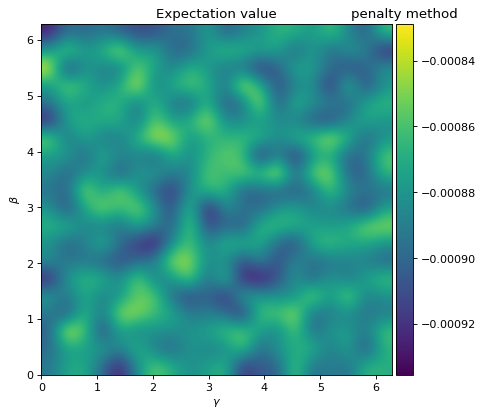

In [7]:
qaoa_penalty.sample_cost_landscape()
plot_E(qaoa_penalty)
pl.title("penalty method")

In [8]:
min_cost, max_cost = qaoa_penalty.problem.computeMinMaxCosts()
min_cost, max_cost

(-0.0016206103192186036, -0.00014331127928856314)

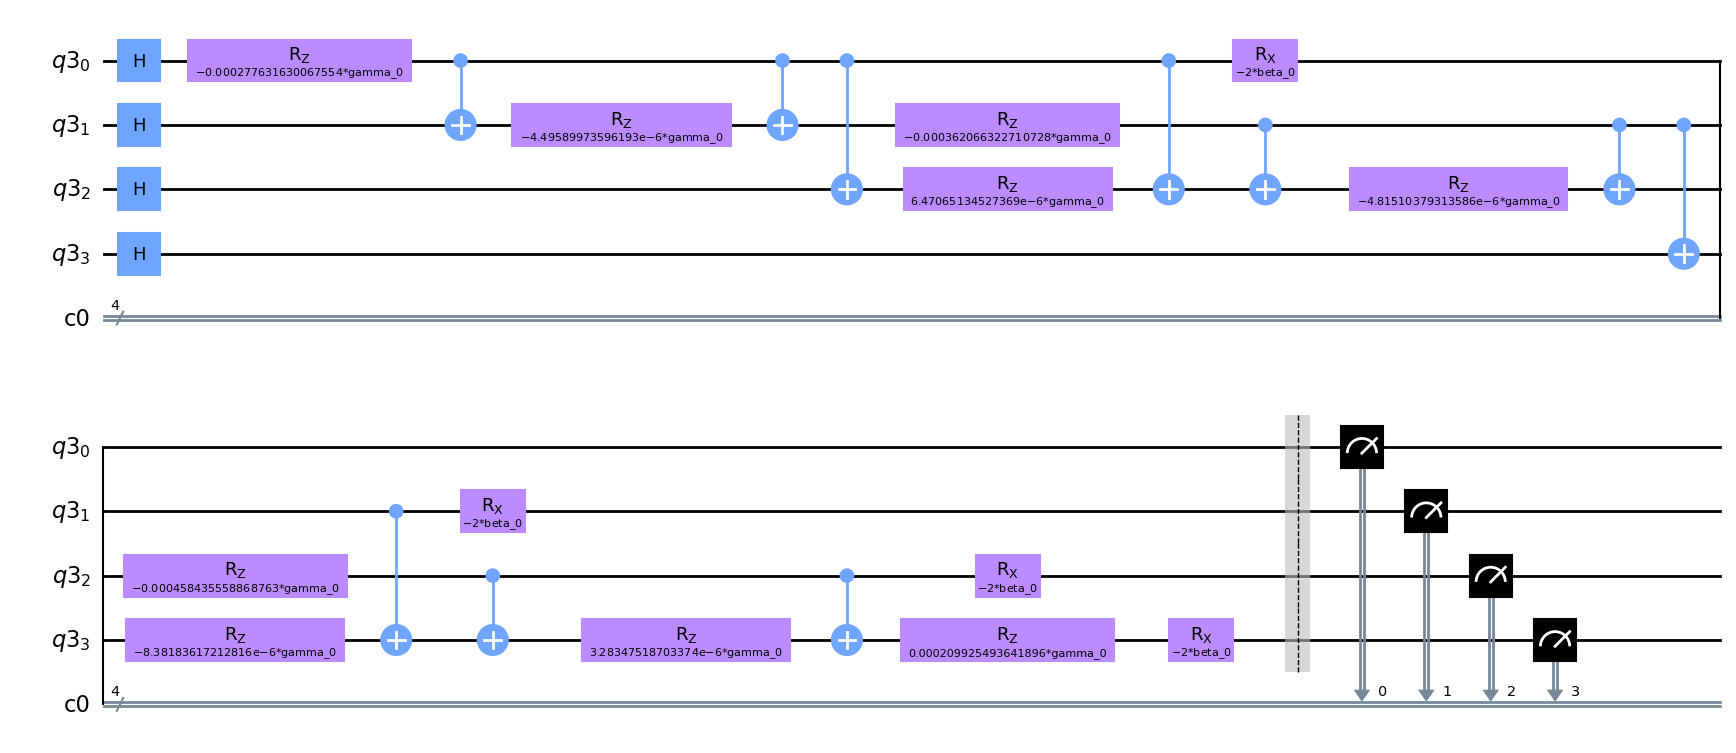

In [9]:
qaoa_penalty.parameterized_circuit.draw(output='mpl')

## Exercise: Find the optimal penalty 

2023-10-12 16:58:45 [info     ] Calculating energy landscape for depth p=1... file=qaoa.qaoa func=sample_cost_landscape
1 0
2023-10-12 16:58:45 [info     ] Executing sample_cost_landscape file=qaoa.qaoa func=sample_cost_landscape
2023-10-12 16:58:45 [info     ] parameters: 2                  file=qaoa.qaoa func=sample_cost_landscape
2023-10-12 16:58:45 [info     ] Done execute                   file=qaoa.qaoa func=sample_cost_landscape
2023-10-12 16:58:46 [info     ] Done measurement               file=qaoa.qaoa func=sample_cost_landscape
2023-10-12 16:58:46 [info     ] Calculating Energy landscape done file=qaoa.qaoa func=sample_cost_landscape


Text(0.5, 1.0, 'penalty method')

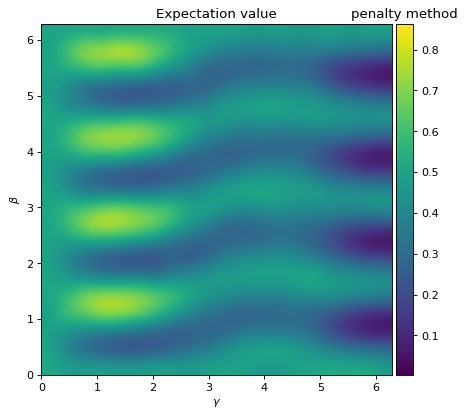

In [10]:
penalty=0.5
rescaling=np.abs(np.pi/(max_cost-min_cost))
qaoa_penalty = QAOA(
    initialstate=initialstates.Plus(),
    problem=get_problem(penalty=penalty),
    mixer=mixers.X()
)
qaoa_penalty.sample_cost_landscape()
plot_E(qaoa_penalty)
pl.title("penalty method")

In [11]:
maxdepth = 10
qaoa_penalty.optimize(depth=maxdepth)

2023-10-12 16:58:46 [info     ] cost(depth 1 = -0.0008843055664454402 file=qaoa.qaoa func=optimize
2023-10-12 16:58:47 [info     ] cost(depth 2 = 0.149543961289501 file=qaoa.qaoa func=optimize
2023-10-12 16:58:48 [info     ] cost(depth 3 = 0.11737696215170594 file=qaoa.qaoa func=optimize
2023-10-12 16:58:49 [info     ] cost(depth 4 = 0.0584020753783939 file=qaoa.qaoa func=optimize
2023-10-12 16:58:51 [info     ] cost(depth 5 = 0.15359583007884606 file=qaoa.qaoa func=optimize
2023-10-12 16:58:54 [info     ] cost(depth 6 = 0.021546723800047234 file=qaoa.qaoa func=optimize
2023-10-12 16:58:58 [info     ] cost(depth 7 = 0.09411327198892085 file=qaoa.qaoa func=optimize
2023-10-12 16:59:05 [info     ] cost(depth 8 = 0.013901572447029515 file=qaoa.qaoa func=optimize
2023-10-12 16:59:13 [info     ] cost(depth 9 = 0.08291491135522562 file=qaoa.qaoa func=optimize
2023-10-12 16:59:21 [info     ] cost(depth 10 = 0.11063008396210931 file=qaoa.qaoa func=optimize


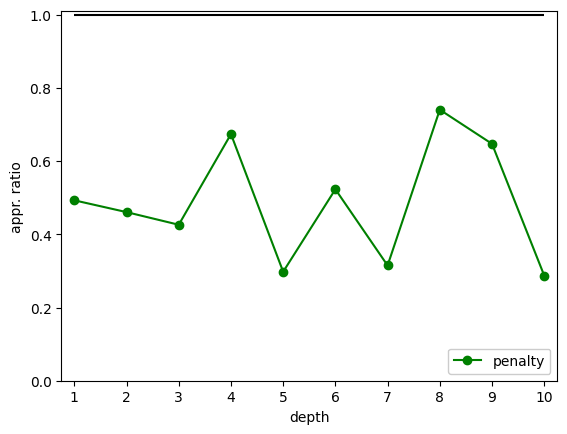

In [12]:
shots = 1024
fig = pl.figure()

plot_ApproximationRatio(
    qaoa_penalty,
    maxdepth,
    mincost=min_cost,
    maxcost=max_cost,
    label="penalty",
    style="og-",
    fig=fig,
    shots=shots,
)

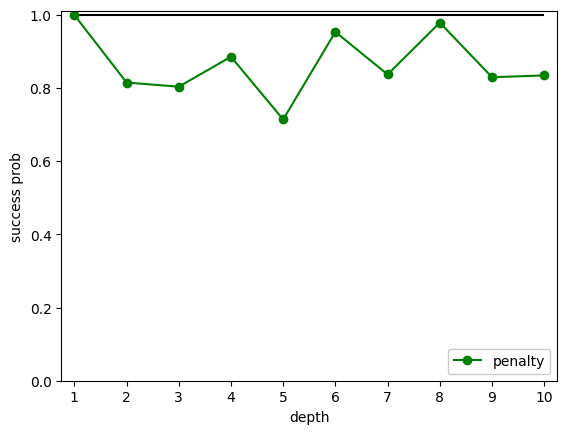

In [13]:
plot_successprob(
    qaoa_penalty, maxdepth, label="penalty", style="og-", fig=pl.figure()
)

# The XY-Mixers 

Instead of introducing a penalty term in the hamiltonian, that has we have seen is difficult to control, we can think to start from an initial state $\ket{\psi_{0}}$ that is in the feasible state and define a new mixer that provide transitions between osly feasible solutions with the fixed budget.

A possible initial state if for example the Dicke state defined as the equal superposition of all the possible N qubits states with B ones (so the superposition of all the possible feasible solutions)

$\ket{\psi_{0}}=\ket{D_{B}^{N}}=\frac{1}{\sqrt{\bigl(\begin{smallmatrix}
N
\\ 
B
\end{smallmatrix}\bigr)}}\sum_{\sum_{x_{i}}=B}\ket{s_{1}...s_{N}}$

This state can be prepared efficiently with a recursive circuit as explained in reference: REFeRENCE

Now we need to find a mixing operator that preserve the initial state budget constrain and permits to explore the feasible Hilbert space. The operator we are going to use is the XY operator defined as 

$XY_{ij}=X_{i}X_{j}+Y_{i}Y_{j}=\begin{pmatrix}
0 & 0 & 0 & 0\\ 
 0&  0& 1 & 0\\ 
 0& 1 & 0 & 0\\ 
 0& 0 & 0 & 0
\end{pmatrix},\quad e^{-i\theta XY}=\begin{pmatrix}
1 & 0 & 0 & 0\\ 
 0&  cos(\theta)& isin(\theta) & 0\\ 
 0& -isin(\theta) & cos(\theta) & 0\\ 
 0& 0 & 0 & 1
\end{pmatrix}$

As we can see only mix between $\ket{01}\leftrightarrow\ket{10}$ so conserving the budget. Now we only need to use enough of this two qubits operators to ensure to explore the whole feasible Hilbert Space. 

Different mixers can be obtained with different performances here we are going to explore some of them.

In [14]:
qaoa_XYmixer_chain= QAOA(
        initialstate=initialstates.DickeState(budget),
        problem=get_problem(rescaling=1),
        mixer=mixers.XY(method="chain"),
)

2023-10-12 16:59:22 [info     ] Calculating energy landscape for depth p=1... file=qaoa.qaoa func=sample_cost_landscape
1 0
2023-10-12 16:59:23 [info     ] Executing sample_cost_landscape file=qaoa.qaoa func=sample_cost_landscape
2023-10-12 16:59:23 [info     ] parameters: 2                  file=qaoa.qaoa func=sample_cost_landscape
2023-10-12 16:59:23 [info     ] Done execute                   file=qaoa.qaoa func=sample_cost_landscape
2023-10-12 16:59:24 [info     ] Done measurement               file=qaoa.qaoa func=sample_cost_landscape
2023-10-12 16:59:24 [info     ] Calculating Energy landscape done file=qaoa.qaoa func=sample_cost_landscape


Text(0.5, 1.0, 'XY chain mixer method')

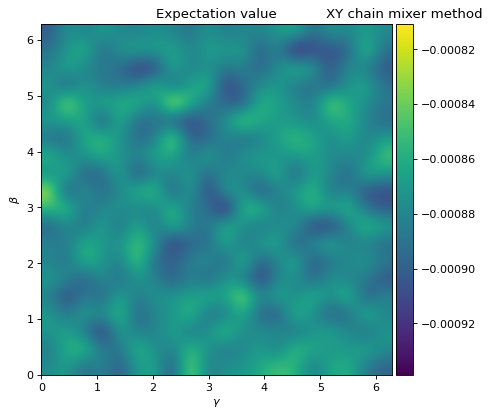

In [15]:
qaoa_XYmixer_chain.sample_cost_landscape()
plot_E(qaoa_XYmixer_chain)
pl.title("XY chain mixer method")

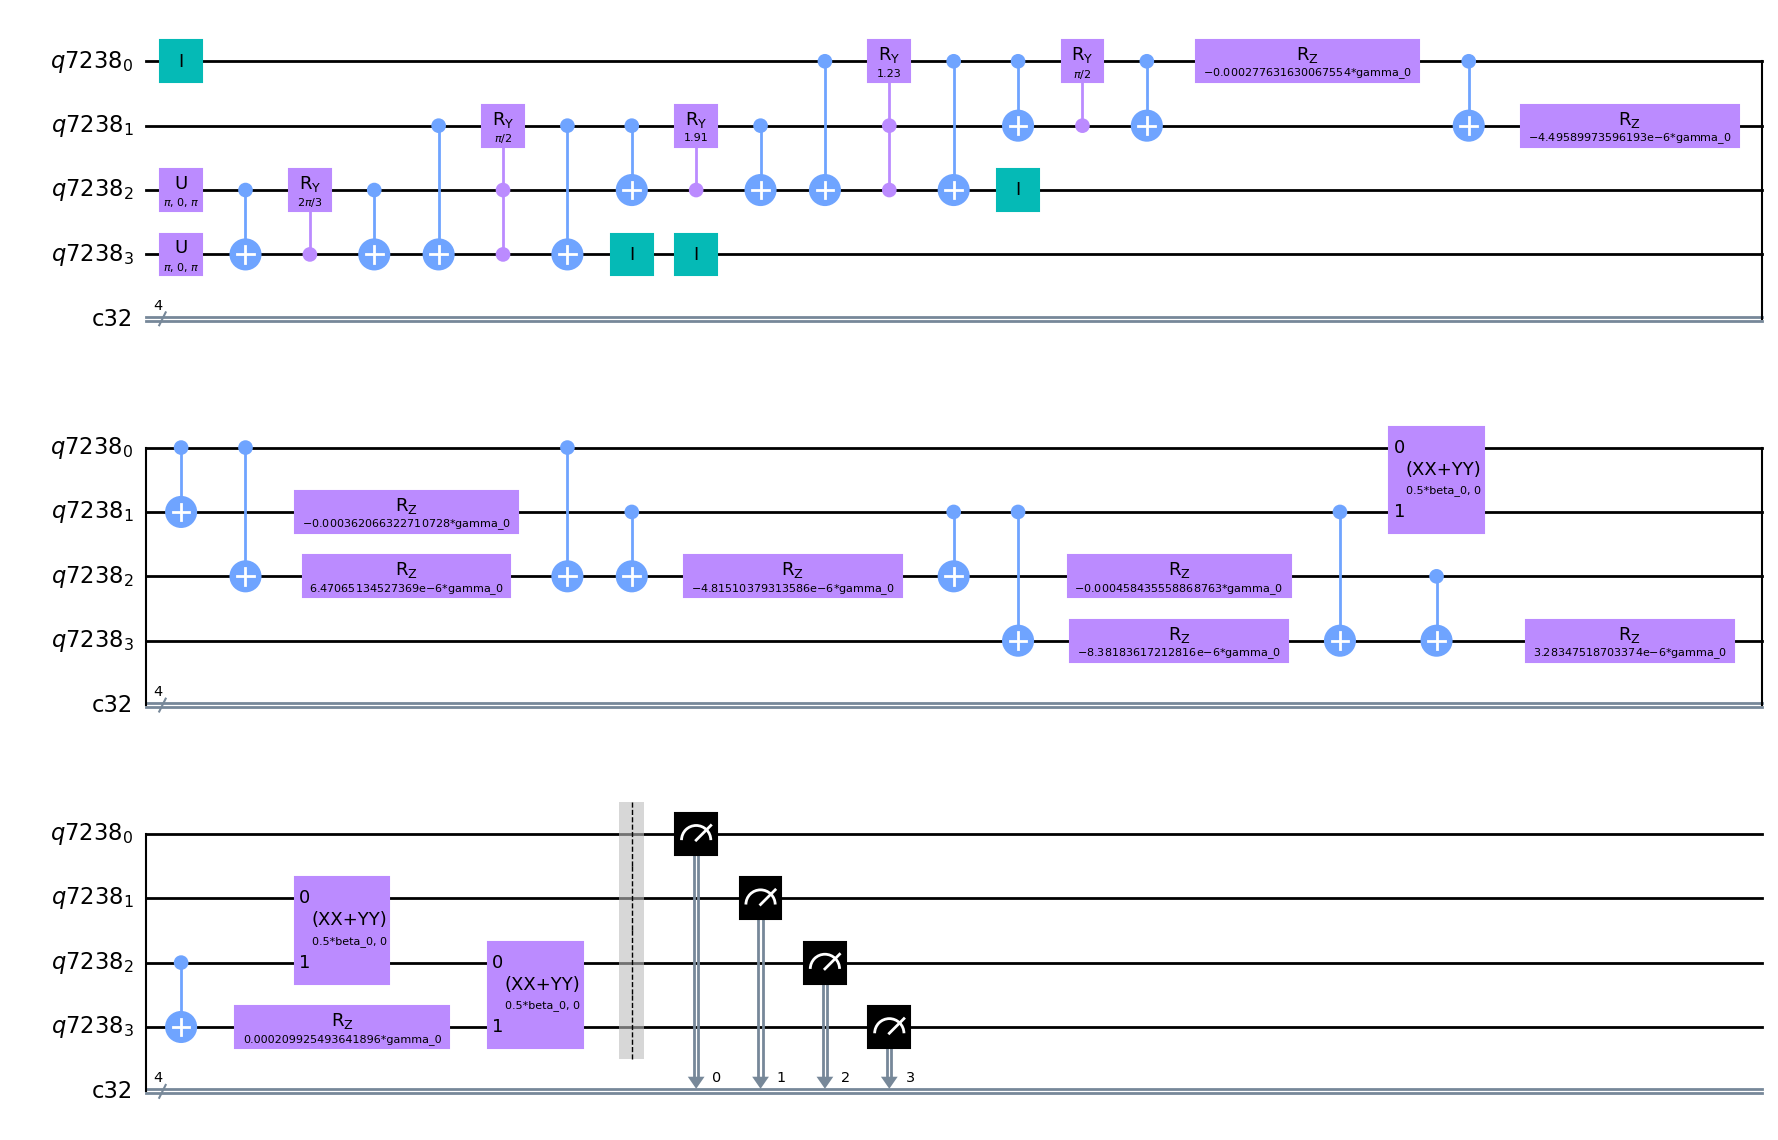

In [16]:
qaoa_XYmixer_chain.parameterized_circuit.draw(output='mpl')

In [17]:
## Exercise: Find the Optimal Rescaling

2023-10-12 16:59:24 [info     ] Calculating energy landscape for depth p=1... file=qaoa.qaoa func=sample_cost_landscape
1 0
2023-10-12 16:59:24 [info     ] Executing sample_cost_landscape file=qaoa.qaoa func=sample_cost_landscape
2023-10-12 16:59:24 [info     ] parameters: 2                  file=qaoa.qaoa func=sample_cost_landscape
2023-10-12 16:59:24 [info     ] Done execute                   file=qaoa.qaoa func=sample_cost_landscape
2023-10-12 16:59:25 [info     ] Done measurement               file=qaoa.qaoa func=sample_cost_landscape
2023-10-12 16:59:25 [info     ] Calculating Energy landscape done file=qaoa.qaoa func=sample_cost_landscape


Text(0.5, 1.0, 'XY ring mixer method')

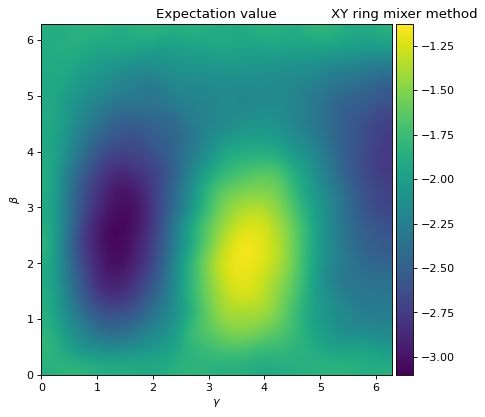

In [18]:
rescaling=np.abs(np.pi/(max_cost-min_cost))


qaoa_XYmixer_chain= QAOA(
        initialstate=initialstates.DickeState(budget),
        problem=get_problem(rescaling=rescaling),
        mixer=mixers.XY(method="ring"),
)
qaoa_XYmixer_chain.sample_cost_landscape()
plot_E(qaoa_XYmixer_chain)
pl.title("XY ring mixer method")

In [19]:
qaoa_XYmixer_chain.optimize(depth=maxdepth)

2023-10-12 16:59:26 [info     ] cost(depth 1 = -3.1046940723185337 file=qaoa.qaoa func=optimize
2023-10-12 16:59:27 [info     ] cost(depth 2 = -3.19795636028032 file=qaoa.qaoa func=optimize
2023-10-12 16:59:29 [info     ] cost(depth 3 = -3.2829387876312297 file=qaoa.qaoa func=optimize
2023-10-12 16:59:32 [info     ] cost(depth 4 = -3.0529500749037775 file=qaoa.qaoa func=optimize
2023-10-12 16:59:37 [info     ] cost(depth 5 = -3.0755379938889833 file=qaoa.qaoa func=optimize
2023-10-12 16:59:43 [info     ] cost(depth 6 = -3.315399587360488 file=qaoa.qaoa func=optimize
2023-10-12 16:59:52 [info     ] cost(depth 7 = -3.20175984116421 file=qaoa.qaoa func=optimize
2023-10-12 16:59:59 [info     ] cost(depth 8 = -3.1933340171940205 file=qaoa.qaoa func=optimize
2023-10-12 17:00:10 [info     ] cost(depth 9 = -3.292552276106214 file=qaoa.qaoa func=optimize
2023-10-12 17:00:25 [info     ] cost(depth 10 = -3.1161502589057206 file=qaoa.qaoa func=optimize


2023-10-12 17:00:25 [info     ] Calculating energy landscape for depth p=1... file=qaoa.qaoa func=sample_cost_landscape
1 0
2023-10-12 17:00:25 [info     ] Executing sample_cost_landscape file=qaoa.qaoa func=sample_cost_landscape
2023-10-12 17:00:25 [info     ] parameters: 2                  file=qaoa.qaoa func=sample_cost_landscape
2023-10-12 17:00:25 [info     ] Done execute                   file=qaoa.qaoa func=sample_cost_landscape
2023-10-12 17:00:27 [info     ] Done measurement               file=qaoa.qaoa func=sample_cost_landscape
2023-10-12 17:00:27 [info     ] Calculating Energy landscape done file=qaoa.qaoa func=sample_cost_landscape


Text(0.5, 1.0, 'XY ring mixer method')

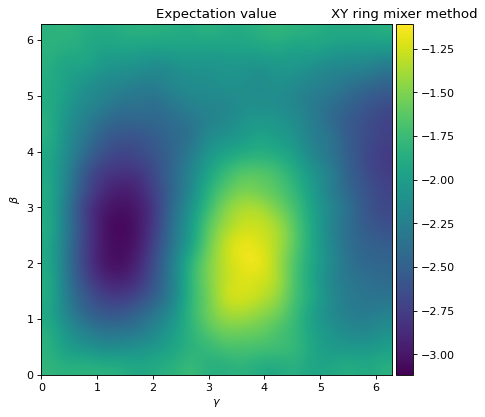

In [20]:
qaoa_XYmixer_ring= QAOA(
        initialstate=initialstates.DickeState(budget),
        problem=get_problem(rescaling=rescaling),
        mixer=mixers.XY(method="ring"),
)
qaoa_XYmixer_ring.sample_cost_landscape()
plot_E(qaoa_XYmixer_ring)
pl.title("XY ring mixer method")

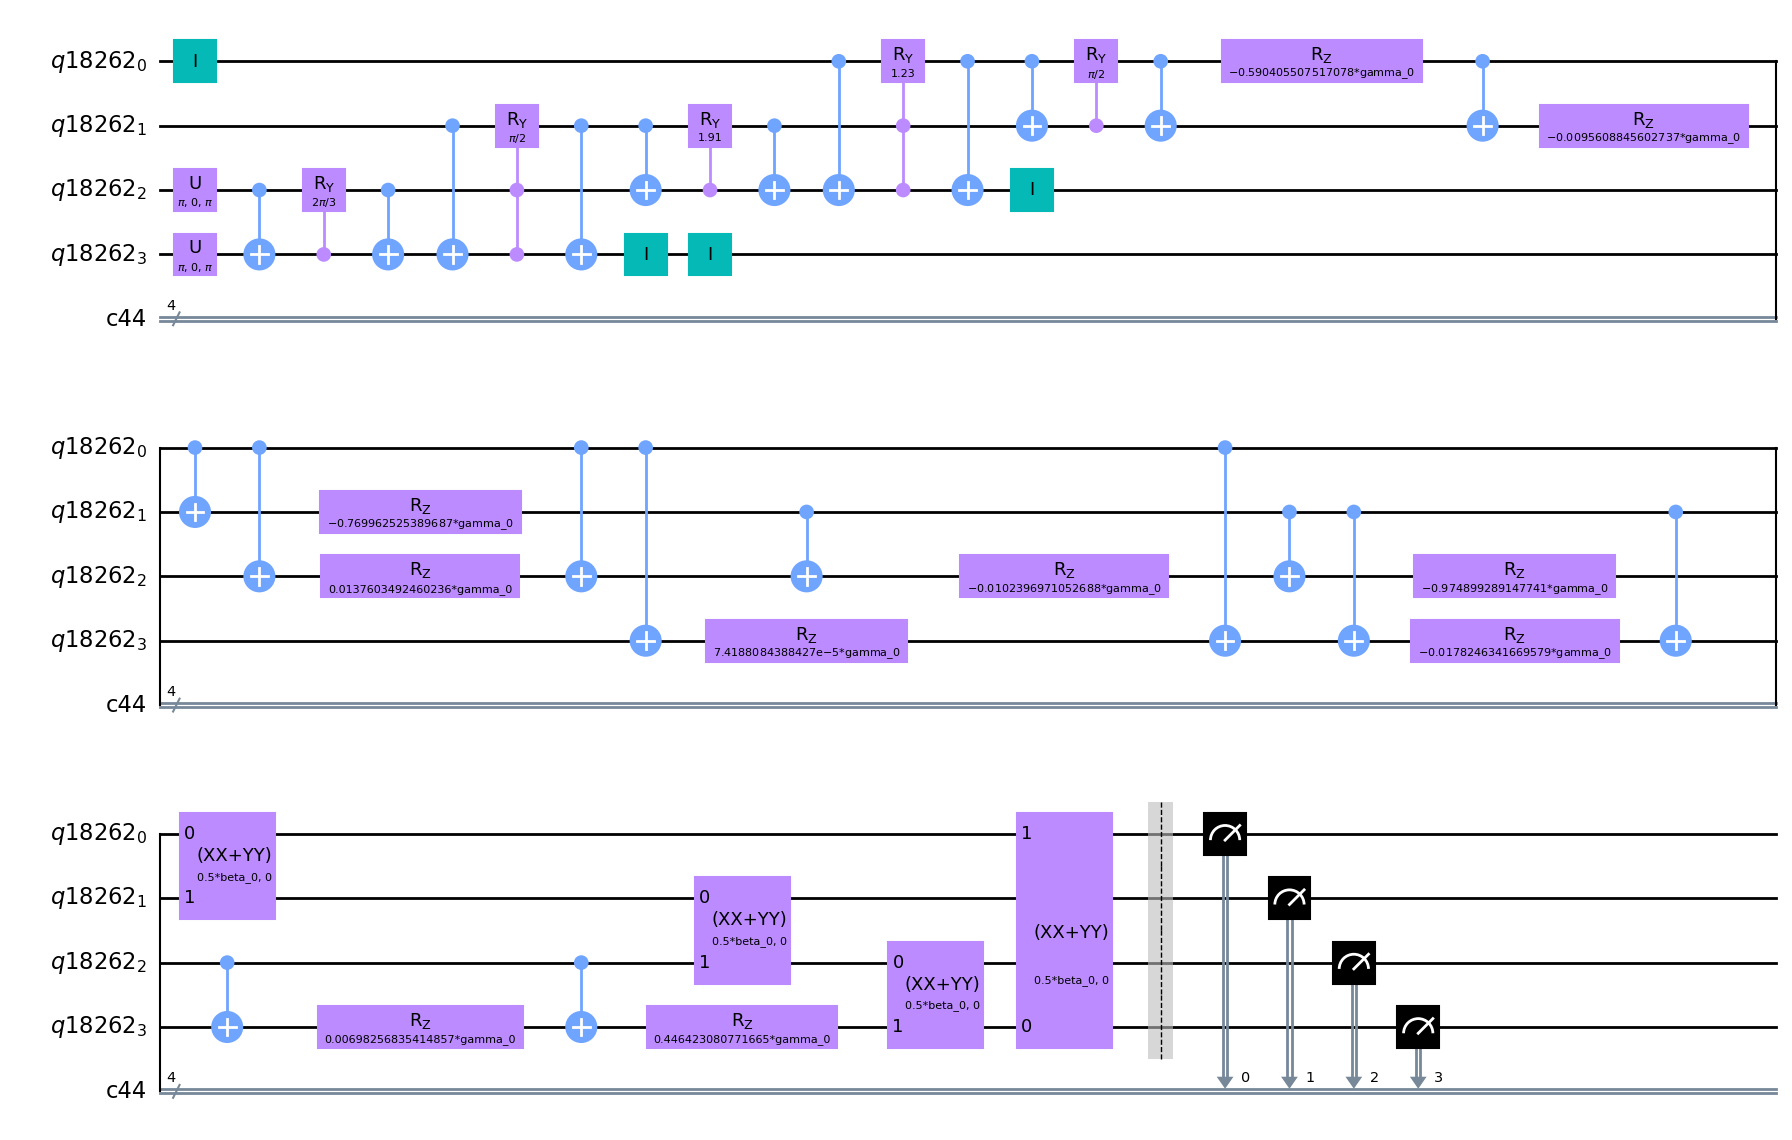

In [21]:
qaoa_XYmixer_ring.parameterized_circuit.draw(output='mpl')

In [22]:
qaoa_XYmixer_ring.optimize(depth=maxdepth)

2023-10-12 17:00:28 [info     ] cost(depth 1 = -3.1296863249725893 file=qaoa.qaoa func=optimize
2023-10-12 17:00:29 [info     ] cost(depth 2 = -2.9158997471563572 file=qaoa.qaoa func=optimize
2023-10-12 17:00:32 [info     ] cost(depth 3 = -3.0050186913282513 file=qaoa.qaoa func=optimize
2023-10-12 17:00:35 [info     ] cost(depth 4 = -3.1542813409750337 file=qaoa.qaoa func=optimize
2023-10-12 17:00:40 [info     ] cost(depth 5 = -3.0619314517183702 file=qaoa.qaoa func=optimize
2023-10-12 17:00:44 [info     ] cost(depth 6 = -3.3084147607652885 file=qaoa.qaoa func=optimize
2023-10-12 17:00:52 [info     ] cost(depth 7 = -3.2922245286815244 file=qaoa.qaoa func=optimize
2023-10-12 17:01:01 [info     ] cost(depth 8 = -3.0675209713362666 file=qaoa.qaoa func=optimize
2023-10-12 17:01:12 [info     ] cost(depth 9 = -3.154501839811604 file=qaoa.qaoa func=optimize
2023-10-12 17:01:25 [info     ] cost(depth 10 = -3.2108594906051735 file=qaoa.qaoa func=optimize


# Exercise: Define a New customize XY mixer 

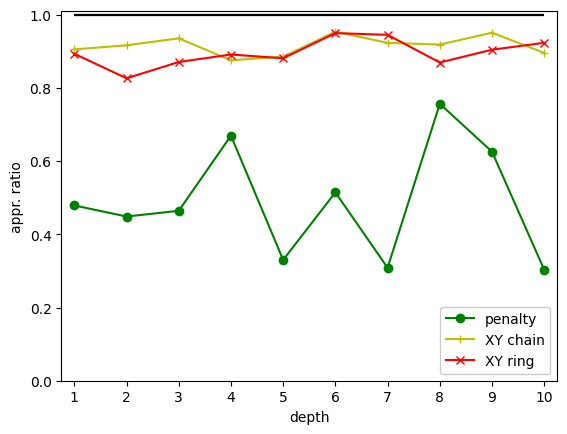

In [23]:
shots = 1024
fig = pl.figure()

plot_ApproximationRatio(
    qaoa_penalty,
    maxdepth,
    mincost=min_cost,
    maxcost=max_cost,
    label="penalty",
    style="og-",
    fig=fig,
    shots=shots,
)
plot_ApproximationRatio(
    qaoa_XYmixer_chain,
    maxdepth,
    mincost=min_cost*rescaling,
    maxcost=max_cost*rescaling,
    label="XY chain",
    style="+y-",
    fig=fig,
    shots=shots,
)
plot_ApproximationRatio(
    qaoa_XYmixer_ring,
    maxdepth,
    mincost=min_cost*rescaling,
    maxcost=max_cost*rescaling,
    label="XY ring",
    style="xr-",
    fig=fig,
    shots=shots,
)


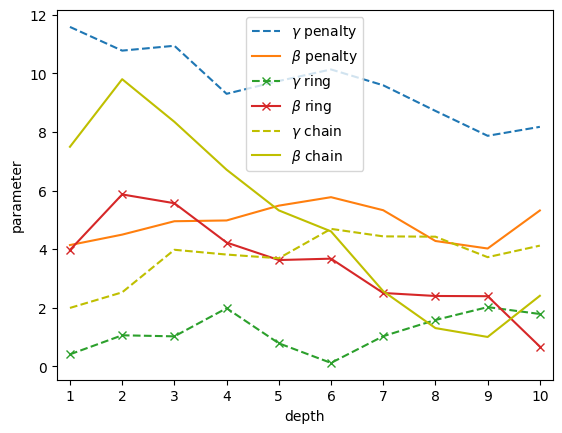

In [27]:
p = maxdepth
fig = pl.figure(p)


plot_angles(qaoa_penalty, p, label='penalty', style='', fig=fig)
plot_angles(qaoa_XYmixer_ring, p, label='ring', style='x', fig=fig)
plot_angles(qaoa_XYmixer_chain, p, label='chain', style='y', fig=fig)